In [1]:
import keras
import pickle
import tensorflow as tf
from keras.models import load_model 
from keras.layers import LSTM, Dense, Input, Add, Embedding, Dropout, TextVectorization
from keras import Model
from keras.utils import load_img
from keras.utils import plot_model, to_categorical, pad_sequences
import matplotlib.pyplot as plt
import numpy as np 
from keras.callbacks import EarlyStopping


FILEPATH = '/Projects/coursework/'
SEQ_LENGTH = 20
BATCH_SIZE = 64

In [2]:
with open(FILEPATH + 'caption_mappings/encoded_captions.pkl', 'rb') as file: 
    caption_mappings = pickle.load(file)
    
with open(FILEPATH + 'feature_mappings/autoencoder_features.pkl', 'rb') as file:
    feature_mappings = pickle.load(file)
    
with open(FILEPATH + 'other/vocabulary.pkl', 'rb') as file: 
    vocab = pickle.load(file)
    
with open(FILEPATH + 'Flicker8k_dataset/Flickr_8k.trainImages.txt') as file: 
    training_images = file.read().strip().split('\n')
    
with open(FILEPATH + 'Flicker8k_dataset/Flickr_8k.devImages.txt') as file: 
    validation_images = file.read().strip().split('\n')

VOCAB_SIZE = len(vocab)
STEPS = len(training_images) / BATCH_SIZE
VAL_STEPS = len(validation_images) / BATCH_SIZE
    

In [3]:
print(len(training_images))

6000


# Model

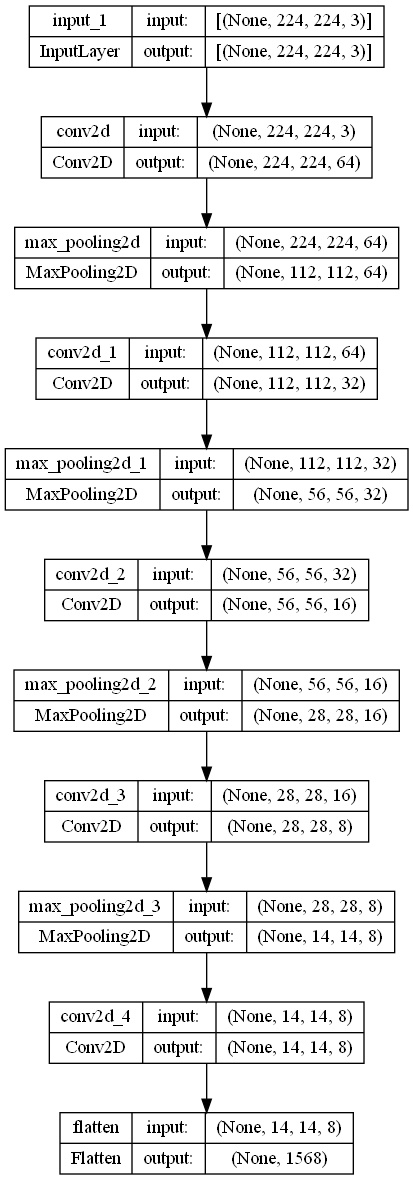

In [4]:
autoencoder = load_model('models/convolution_autoencoder.keras')

plot_model(autoencoder, show_shapes = True, to_file='figures/autoencoder.png')

In [5]:
encoder_output = autoencoder.output.shape[1]

# Image layers
image_input = Input(shape=(encoder_output,))
image_dropout = Dropout(0.4)(image_input)
image_dense = Dense(256, activation = 'relu')(image_dropout)

# Sequence layers
sequence_input = Input(shape=(SEQ_LENGTH,))
sequence_embedding = Embedding(VOCAB_SIZE, 300, input_length = SEQ_LENGTH, mask_zero = True)(sequence_input)
embedding_dropout = Dropout(0.4)(sequence_embedding)
lstm = LSTM(256, return_sequences=True) (embedding_dropout)

# Combine image and sequence
merging_layer = Add()([image_dense, lstm])

# Prediction layers
merging_dense = Dense(256 , activation ='relu')(merging_layer)
output = Dense(VOCAB_SIZE , activation ='softmax')(merging_dense)

# Combining the layers to 
lstm_decoder = Model(inputs=[image_input, sequence_input], outputs=output, name='lstm_decoder')

lstm_decoder.summary()

Model: "lstm_decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1568)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 300)      2635500     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1568)         0           ['input_1[0][0]']                
                                                                                       

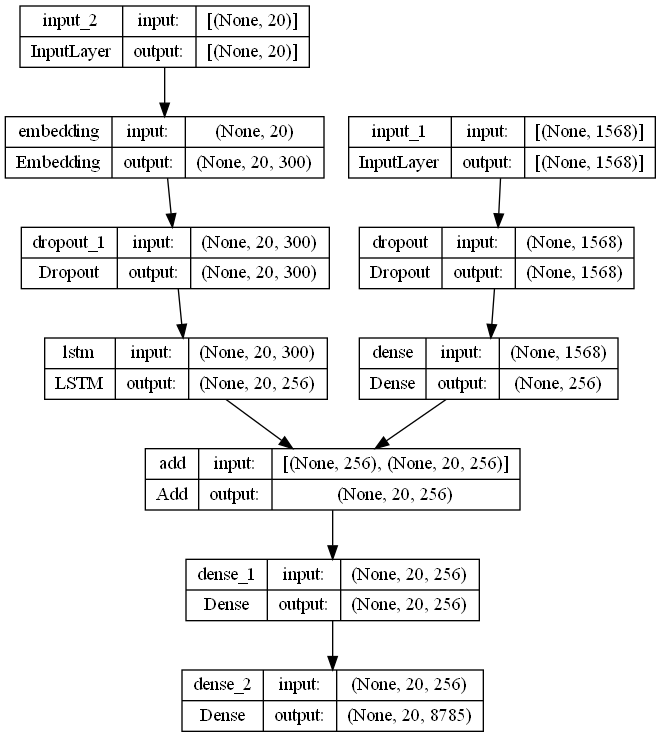

In [6]:
plot_model(lstm_decoder, show_shapes = True, to_file='figures/lstm_decoder_for_autoencoder.png')

In [7]:
encoder_input = Input(shape=(224, 224, 3))
encoder_output = autoencoder(encoder_input)
decoder_input = Input(shape=(SEQ_LENGTH,))
decoder_output = lstm_decoder([encoder_output, decoder_input])

autoencoder_with_lstm = Model(inputs=[encoder_input, decoder_input], outputs = decoder_output, name = 'convolution_autoencoder_with_lstm_decoder')

### Data Generation

In [8]:
with open('Flicker8k_dataset\Flickr_8k.Images.txt', 'r') as file:
    images = file.read().strip().split('\n')

In [9]:
## function for extracting feature from the autoencoder encoder 
def load_image_data(image_name):
    image_path = tf.io.gfile.join(FILEPATH, 'Flicker8k_dataset/Flicker8k_images/', image_name)
    image_data = tf.io.read_file(image_path)
    image_data = tf.image.decode_jpeg(image_data, channels=3)
    image_data = tf.image.resize(image_data, [224, 224])
    image_data = image_data / 255
    return image_data

def create_batches(images, batch_size):
    for i in range(0, len(images), batch_size):
        yield images[i:i + batch_size]        
        
def batch_extract_features(images):
    feature_mappings = {}
    
    for batch in create_batches(images, 1024):
        image_data = [load_image_data(img_path) for img_path in batch] 
        image_data = tf.convert_to_tensor(image_data)     

        extracted_features = autoencoder.predict(image_data, verbose=1)

        for i, img_features in enumerate(extracted_features):
            img_name = batch[i]
            feature_mappings[img_name] = img_features

        del image_data
        del extracted_features
        
        tf.keras.backend.clear_session()
        import gc
        gc.collect()

    with open("feature_mappings/autoencoder_features.pkl", "wb") as file:
            pickle.dump(feature_mappings, file)
    
    return feature_mappings

In [10]:
image_features = batch_extract_features(images)

29/29 [==============================] - 0s 15ms/step


In [11]:
def data_generator(list_of_images):
    x1, x2, y = [], [], []
    current_batch_size = 0 
        
    while True:
        for image in list_of_images:
            features = feature_mappings[image]
            captions = caption_mappings[image]
                                            
            for sequence in captions:
                    input_seq = sequence[:-1]
                    target_seq = sequence[1:]
                    
                    x1.append(features)
                    x2.append(input_seq)
                    y.append(target_seq)
                    
            current_batch_size += 1

            if current_batch_size == BATCH_SIZE:
                try :
                    y = to_categorical(y, num_classes=VOCAB_SIZE)
                    yield [tf.convert_to_tensor(x1), tf.convert_to_tensor(x2)], tf.convert_to_tensor(y)
                except GeneratorExit:
                    print("Generator is being closed")
                    raise 
                
                x1, x2, y = [], [], []
                current_batch_size = 0

In [12]:
for batch in data_generator(validation_images):
    print(batch[0][0].shape)
    print(batch[0][1].shape)
    print(batch[1].shape)
    
    for i in range(5):
        print(batch[0][1][i].numpy())
        print(np.argmax(batch[1][0][i].numpy()))
    break


(320, 1568)
(320, 20)
(320, 20, 8785)
[   3    6   17  265  124   37    7    2  135    8  176 1648  114    6
  170   55   71   17    4    0]
6
[   3   14   81   87    7    2  135    5    2 1038    4    0    0    0
    0    0    0    0    0    0]
17
[  3  14  24  87   7   2 196 135   4   0   0   0   0   0   0   0   0   0
   0   0]
265
[  3  14  53  63   5  26 369  35   7   2 135   4   0   0   0   0   0   0
   0   0]
124
[  3  14  27  63   7   2 135 315 125   2 163   4   0   0   0   0   0   0
   0   0]
37
Generator is being closed


In [13]:
lstm_decoder.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
EPOCHS = 30

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

In [15]:
training_data = data_generator(training_images)
validation_data = data_generator(validation_images)

training = lstm_decoder.fit(
    training_data, 
    epochs=EPOCHS, 
    steps_per_epoch=STEPS,
    validation_data=validation_data,
    validation_steps=VAL_STEPS,
    verbose=1
)


Epoch 1/30
93/93 [==============================] - 52s 522ms/step - loss: 3.3360 - accuracy: 0.1807 - val_loss: 2.9635 - val_accuracy: 0.2501
Epoch 2/30
93/93 [==============================] - 39s 420ms/step - loss: 2.6173 - accuracy: 0.3032 - val_loss: 2.4640 - val_accuracy: 0.3302
Epoch 3/30
93/93 [==============================] - 44s 473ms/step - loss: 2.3103 - accuracy: 0.3484 - val_loss: 2.3217 - val_accuracy: 0.3622
Epoch 4/30
93/93 [==============================] - 39s 416ms/step - loss: 2.1518 - accuracy: 0.3701 - val_loss: 2.2211 - val_accuracy: 0.3747
Epoch 5/30
93/93 [==============================] - 43s 458ms/step - loss: 2.0427 - accuracy: 0.3833 - val_loss: 2.1686 - val_accuracy: 0.3818
Epoch 6/30
93/93 [==============================] - 47s 501ms/step - loss: 1.9677 - accuracy: 0.3928 - val_loss: 2.1338 - val_accuracy: 0.3883
Epoch 7/30
93/93 [==============================] - 51s 554ms/step - loss: 1.9021 - accuracy: 0.4002 - val_loss: 2.1175 - val_accuracy: 0.3938

In [16]:
idx_to_word = {i: word for i, word in enumerate(vocab)}

start_token = 3
end_token = 4

def decode_caption(caption):
    decoded_caption = []
    
    for word in caption: 
        if word == start_token or word == 0:
            continue
        if word == end_token: 
            break
        else: 
            token =  idx_to_word[word] 
            decoded_caption.append(token) 
            
    return decoded_caption
    
def generate_caption(image):
    features = feature_mappings[image]
    features = np.expand_dims(features, axis= 0)
   
    caption = [start_token]
            
    for i in range(SEQ_LENGTH):  
        input_seq = pad_sequences([caption], maxlen=SEQ_LENGTH, padding='post')
        prediction = lstm_decoder.predict([features, input_seq], verbose = 0)[0]
        
        word_idx = np.argmax(prediction[i])
          
        caption.append(word_idx) 
        
        if word_idx == end_token:
            break
                
    return decode_caption(caption)

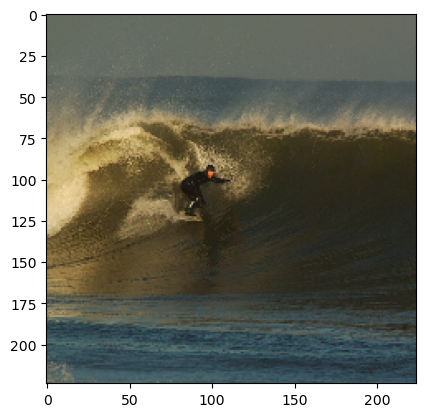

a man in a blue shirt is standing on a rock

True captions: 
a man stands on a surfboard and coasts down a large wave
a surfer catches a large wave
a surfer rides the waves
a surfer surfs across the large wave
the surfer in the wetsuit is riding a wave


In [25]:
test_image = np.random.choice(training_images)
image_data = load_image_data(test_image)

plt.imshow(image_data)
plt.show()

prediction = generate_caption(test_image)
print(' '.join(prediction))
true_captions = caption_mappings[test_image]
print('\nTrue captions: ')
for caption in true_captions: 
    print(' '.join(decode_caption(caption.numpy())))

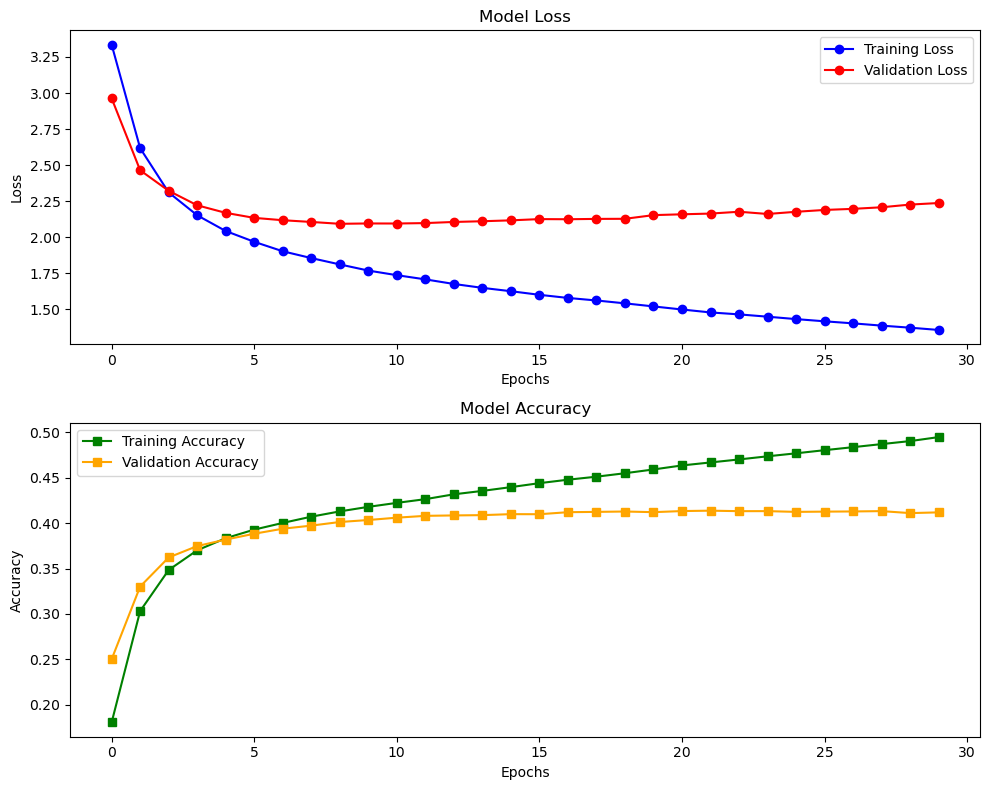

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plotting Loss
axes[0].plot(training.history['loss'], marker='o', color='b', label='Training Loss')
axes[0].plot(training.history['val_loss'], marker='o', color='r', label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting Accuracy
axes[1].plot(training.history['accuracy'], marker='s', color='g', label='Training Accuracy')
axes[1].plot(training.history['val_accuracy'], marker='s', color='orange', label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()